# Catheter Project Convolutional Neural Networks component

Let's try a computationally expensive method involving a hybrid of the images themselves, the annotations and the unannotated images as the testing set. The proposed method is to increase pixel intensity of the annotated areas during training and validating so the CNN's propagation process can converge to these areas. Hopefully, these learnings will carry over to the test images which have no annotations and produce accurate results. Let's use the preprepared directory formed by the other notebook, "Catheter file management". The file directories are formed such that each image is pre split into training, testing and validating sets and separated by class already.

In [31]:
import pandas as pd
import cv2
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
RS=42#set random seed consistent do not change
height,width,channels=224,224,1#image data structure
from sklearn.metrics import classification_report,confusion_matrix
num_classes=3

In [2]:
def set_files_on_dataframe(df,tag='StudyInstanceUID'):
  '''
  df: target data frame
  tag: StudyInstanceUID
  '''
  if 'image_file' not in df.columns:
    df['image_file']=''
  for i,row in df.iterrows():
    if '.jpg' not in row[tag]:
      path=row[tag]+'.jpg'
      df._set_value(i,'image_file',path)
    elif '.jpg' in row[tag]:
      path=row[tag]
      df._set_value(i,'image_file',path)
  return df

In [3]:
train=pd.read_csv('train.csv')
train_annots=pd.read_csv('train_annotations.csv')
train=set_files_on_dataframe(train)
train_annots=set_files_on_dataframe(train_annots)

In [4]:
def clean_dataframe(df,cath_type):
    '''
    only runs for train, not train annotations
    '''
    if cath_type == 'CVC' or cath_type == 'ETT':
        dataframe=df[['StudyInstanceUID',cath_type+' - Abnormal',cath_type+' - Normal',cath_type+' - Borderline','image_file']]
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 0) & (dataframe[cath_type+' - Normal'] == 0) & (dataframe[cath_type+' - Borderline'] == 0)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 1) & (dataframe[cath_type+' - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Borderline'] == 1) & (dataframe[cath_type+' - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe[cath_type+' - Abnormal'] == 1) & (dataframe[cath_type+' - Borderline'] == 1)].index)
    elif cath_type == 'NGT':
        dataframe=df[['StudyInstanceUID','NGT - Abnormal','NGT - Normal','NGT - Borderline','NGT - Incompletely Imaged','image_file']]
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 0) & (dataframe['NGT - Normal'] == 0) & (dataframe['NGT - Borderline'] == 0) & (dataframe['NGT - Incompletely Imaged']==0)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Incompletely Imaged']==1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 1) & (dataframe['NGT - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Borderline'] == 1) & (dataframe['NGT - Normal'] == 1)].index)
        dataframe=dataframe.drop(dataframe[(dataframe['NGT - Abnormal'] == 1) & (dataframe['NGT - Borderline'] == 1)].index)
    return dataframe

In [5]:
#manual hot encode
def encoder(df,cath_type):
  '''
  works only with train annots file
  '''
  outcomes=[]
  for i in range(len(df)):
    if df.loc[i,'label']==cath_type+' - Normal':
      outcomes.append(0)
    if df.loc[i,'label']==cath_type+' - Abnormal':
      outcomes.append(1)
    if df.loc[i,'label']==cath_type+' - Borderline':
      outcomes.append(2)
  df['outcome']=outcomes
  return df

In [6]:
ett_annots=train_annots[(train_annots['label']=='ETT - Normal')|(train_annots['label']=='ETT - Abnormal')|(train_annots['label']=='ETT - Borderline')]
ett_annots.reset_index(drop=True,inplace=True)
cvc_annots=train_annots[(train_annots['label']=='CVC - Normal')|(train_annots['label']=='CVC - Abnormal')|(train_annots['label']=='CVC - Borderline')]
cvc_annots.reset_index(drop=True,inplace=True)
ngt_annots=train_annots[(train_annots['label']=='NGT - Normal')|(train_annots['label']=='NGT - Abnormal')|(train_annots['label']=='NGT - Borderline')]
ngt_annots.reset_index(drop=True,inplace=True)

In [7]:
def count_files_in_directory(directory):
    file_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_count += 1
    return file_count

In [8]:
def list_abs_paths_in_dir(directory):
  # Initialize an empty list to store the absolute paths to files
  file_paths = []
  # files=[]
  # Use os.walk() to traverse through the directory and its subdirectories
  for root, dirs, files in os.walk(directory):
      for file in files:
          # Construct the absolute path to the file
          file_path = os.path.abspath(os.path.join(root, file))

          # Append the absolute path to the list
          file_paths.append(file_path)
          # files.append(os.path.basename(file_path))
  return file_paths
def get_filenames_of_abs_paths(absfiles):
  '''
  can only pass after listing absolute paths
  '''
  basefiles=[]
  for i in absfiles:
    basefiles.append(os.path.basename(i))
  return basefiles

In [9]:
paths_ngt=list_abs_paths_in_dir('images_split/NGT/train')+list_abs_paths_in_dir('images_split/NGT/validate')+list_abs_paths_in_dir('images_split/NGT/test')
files_ngt=get_filenames_of_abs_paths(paths_ngt)
ngt_data={'file path':paths_ngt,'image_file':files_ngt}
ngt_abs_df_tv=pd.DataFrame(ngt_data)
ngt_abs_df_tv.sort_values(by=['image_file'],inplace=True)
ngt_annots_tv=ngt_annots[ngt_annots['image_file'].isin(ngt_abs_df_tv['image_file'].tolist())]
ngt_annots_tv.sort_values(by=['image_file'],inplace=True)
ngt_annots_tv.reset_index(drop=True,inplace=True)
ngt_annots_tv=ngt_annots_tv.merge(ngt_abs_df_tv,on='image_file')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
paths_cvc=list_abs_paths_in_dir('images_split/CVC/train')+list_abs_paths_in_dir('images_split/CVC/validate')+list_abs_paths_in_dir('images_split/CVC/test')
files_cvc=get_filenames_of_abs_paths(paths_cvc)
cvc_data={'file path':paths_cvc,'image_file':files_cvc}
cvc_abs_df_tv=pd.DataFrame(cvc_data)
cvc_abs_df_tv.sort_values(by=['image_file'],inplace=True)
cvc_annots_tv=cvc_annots[cvc_annots['image_file'].isin(cvc_abs_df_tv['image_file'].tolist())]
cvc_annots_tv.sort_values(by=['image_file'],inplace=True)
cvc_annots_tv.reset_index(drop=True,inplace=True)
cvc_annots_tv=cvc_annots_tv.merge(cvc_abs_df_tv,on='image_file')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [11]:
paths_ett=list_abs_paths_in_dir('images_split/ETT/train')+list_abs_paths_in_dir('images_split/ETT/validate')+list_abs_paths_in_dir('images_split/ETT/test')
files_ett=get_filenames_of_abs_paths(paths_ett)
ett_data={'file path':paths_ett,'image_file':files_ett}
ett_abs_df_tv=pd.DataFrame(ett_data)
ett_abs_df_tv.sort_values(by=['image_file'],inplace=True)
ett_annots_tv=ett_annots[ett_annots['image_file'].isin(ett_abs_df_tv['image_file'].tolist())]
ett_annots_tv.sort_values(by=['image_file'],inplace=True)
ett_annots_tv.reset_index(drop=True,inplace=True)
ett_annots_tv=ett_annots_tv.merge(ett_abs_df_tv,on='image_file')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
def add_feature(df):
  '''
  must reset index
  '''
  df.reset_index(drop=True,inplace=True)
  if 'image' not in df.columns:
    df['image']=''
  for i, row in df.iterrows():
    feature = cv2.imread(row['file path'], cv2.IMREAD_GRAYSCALE)
    df._set_value(i,'image',feature)
  return df

In [13]:
def resize_annots(df):
  '''
  requires df input to have an image column containing the array rep of the image
  '''
  resized_coords = []
  for i in range(len(df)):
    shape = df.loc[i,'image'].shape
    N = shape[1] #y-values
    M = shape[0] #x-values
    data = np.array(ast.literal_eval(df.loc[i,'data']))
    X = data[:, 0]
    Y = data[:, 1]
    x = np.round((X/N)*224,3)
    y = np.round((Y/M)*224,3)
    new_data = str([[a, b] for a, b in zip(x, y)])
    resized_coords.append(new_data)
  df['resized data'] = resized_coords
  return df

In [14]:
cath='NGT'
trial=add_feature(ngt_annots_tv)
trial=resize_annots(trial)
trial=encoder(trial,cath)

In [15]:
def plot_loss(history,model_type,cath_type):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([min(min(history.history['val_loss']),min(history.history['loss'])),max(max(history.history['loss']),max(history.history['val_loss']))])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.title('Error plot for the '+model_type+' using '+cath_type+' data')  
  plt.legend()
  plt.grid(True)

In [16]:
def plt_cnf_mat(model,cath,true_labels,preds):
    conf_matrix = confusion_matrix(true_labels, preds)
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )

    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted Placement", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Normal','Abnormal','Borderline'])

    # set y-axis label and ticks
    ax.set_ylabel("Actual Placement", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Normal','Abnormal','Borderline'])

    # set plot title
    ax.set_title("Confusion Matrix for the " + model+ " on "+cath, fontsize=14, pad=20)
    correct_predictions = np.sum(np.array(preds) == true_labels)
    total_predictions = len(true_labels)
    accuracy = correct_predictions / total_predictions
    print(f"{model} accuracy is {accuracy}")
    plt.show()

In [17]:
#ChatGPT: How do I build a ResNet-50 CNN
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

def build_resnet50(input_shape, num_classes):
    # Define the input layer with the specified shape
    input_tensor = Input(shape=input_shape)

    # Load the ResNet-50 model without the top classification layers
    base_model = ResNet50(include_top=False, input_tensor=input_tensor)

    # Add your own classification head on top of the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=input_tensor, outputs=x)

    return model

# Specify the input shape for your generator's image_batch
input_shape = (height, width, 3)

# Specify the number of classes
num_classes = 3  # Number of classes in your classification task

# Build the ResNet-50 model
model = build_resnet50(input_shape, num_classes)

# Compile the model with your preferred optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [19]:
from tensorflow.keras.utils import Sequence, to_categorical
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, coordinate_list, batch_size, pixel_intensity_function):
        self.image_paths = image_paths
        self.labels = labels
        self.coordinate_list = coordinate_list
        self.batch_size = batch_size
        self.pixel_intensity_function = pixel_intensity_function
        self.image_data_generator = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.2
        )
#         print('debug init')

    def __len__(self):
#         print('debug len')
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size

        image_batch = self.load_and_preprocess_images(start_idx, end_idx)

        labels = self.labels[start_idx:end_idx]

        # One-hot encode list-form labels
        label_batch = to_categorical(labels, num_classes=num_classes)

        return image_batch, label_batch
    
    def load_and_preprocess_images(self, start_idx, end_idx):
        image_batch = []
        for i in range(start_idx, end_idx):
            if i < len(self.coordinate_list):
                image = self.load_image(self.image_paths[i])
                modified_image = self.modify_image_intensity(image, self.coordinate_list[i])
                image_batch.append(modified_image)
        return np.array(image_batch)
        
    def modify_image_intensity(self, image, coordinates):
#         print('debug mod start')
        modified_image = self.pixel_intensity_function(image, coordinates)
#         print('debug mod fin')
        return modified_image
    
    def load_image(self, image_path, target_size=(224, 224)):
        # Load the grayscale image using PIL
        image = Image.open(image_path)

        # Optionally, resize the image to the target size
        if target_size is not None:
            image = image.resize(target_size)

        # Convert the image to a numerical array
        image_array = np.array(image)

        # Expand dimensions to represent a three-channel image
        image_array = np.stack((image_array,) * 3, axis=-1)

        # Normalize the pixel values (optional)
        image_array = image_array / 255.0

        return image_array

    
def increase_pixel_intensity(image,coordinates):
    # Create a copy of the image to avoid modifying the original
    modified_image = np.copy(image)
    # Increase the pixel intensity at the specified coordinates
    for (x, y) in coordinates:
        # You can adjust the increase amount as needed
        try:
            modified_image[x, y] += np.max(image)
        except IndexError:
            pass
#     print('debug increase pi end')
    return modified_image
    

In [20]:
#early stopper
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
reducelr_cb = ReduceLROnPlateau(monitor='lr', factor=0.5, patience=2)
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True)

In [21]:
cath='NGT'
training_dir = 'images_split/'+cath+'/train'
training_abs_files=list_abs_paths_in_dir(training_dir)
training_filenames=get_filenames_of_abs_paths(training_abs_files)

val_dir = 'images_split/'+cath+'/validate'
val_abs_files=list_abs_paths_in_dir(val_dir)
val_filenames=get_filenames_of_abs_paths(val_abs_files)

# Create two dataframes for training and validation
training_df = trial[trial['image_file'].isin(training_filenames)]
validation_df = trial[trial['image_file'].isin(val_filenames)]
training_df = training_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
training_df.drop_duplicates(subset='StudyInstanceUID', keep="first",inplace=True)
validation_df.drop_duplicates(subset='StudyInstanceUID', keep="first",inplace=True)

train_image_paths=list_abs_paths_in_dir(training_dir)
train_labels=training_df['outcome'].tolist()
batch_size=32
train_coord_list=training_df['resized data'].tolist()
for i in range(len(train_coord_list)):
    train_coord_list[i]=list(ast.literal_eval(train_coord_list[i]))
    for j in range(len(train_coord_list[i])):
        train_coord_list[i][j]=tuple(train_coord_list[i][j])        
train_data_generator = CustomDataGenerator(train_image_paths,train_labels, train_coord_list, batch_size, increase_pixel_intensity)

val_image_paths=list_abs_paths_in_dir(val_dir)
val_labels=validation_df['outcome'].tolist()
batch_size=32
val_coord_list=validation_df['resized data'].tolist()
for i in range(len(val_coord_list)):
    val_coord_list[i]=list(ast.literal_eval(val_coord_list[i]))
    for j in range(len(val_coord_list[i])):
        val_coord_list[i][j]=tuple(val_coord_list[i][j])        
val_data_generator = CustomDataGenerator(val_image_paths,val_labels, val_coord_list, batch_size, increase_pixel_intensity)
# historyCNN=model.fit(train_data_generator,epochs=10,validation_data=val_data_generator,verbose=2,
#          callbacks=[reducelr_cb,early_stopping_cb])

Epoch 1/10
21/21 - 70s - loss: 1.4545 - accuracy: 0.5734 - val_loss: 6058.6230 - val_accuracy: 0.0854
Epoch 2/10
21/21 - 63s - loss: 0.9574 - accuracy: 0.6082 - val_loss: 1.8541 - val_accuracy: 0.5854
Epoch 3/10
21/21 - 63s - loss: 0.9562 - accuracy: 0.6067 - val_loss: 0.9390 - val_accuracy: 0.5854
Epoch 4/10
21/21 - 66s - loss: 0.8691 - accuracy: 0.6127 - val_loss: 0.9310 - val_accuracy: 0.5854
Epoch 5/10
21/21 - 67s - loss: 0.8200 - accuracy: 0.6082 - val_loss: 1.5050 - val_accuracy: 0.5854
Epoch 6/10
21/21 - 66s - loss: 0.7677 - accuracy: 0.6324 - val_loss: 3.1133 - val_accuracy: 0.5854
Epoch 7/10
21/21 - 66s - loss: 0.6470 - accuracy: 0.6778 - val_loss: 4.4298 - val_accuracy: 0.5854


INFO:tensorflow:Assets written to: CNN models/NGT/assets


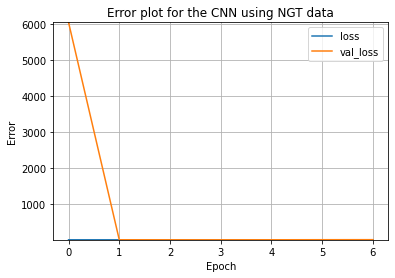

In [22]:
model.save("CNN models/"+cath)
plot_loss(historyCNN,'CNN',cath)

CNN accuracy is 0.5903614457831325


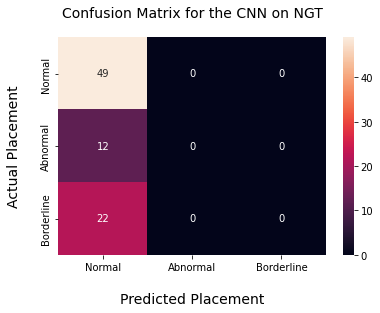

              precision    recall  f1-score   support

      Normal       0.59      1.00      0.74        49
    Abnormal       0.00      0.00      0.00        12
  Borderline       0.00      0.00      0.00        22

    accuracy                           0.59        83
   macro avg       0.20      0.33      0.25        83
weighted avg       0.35      0.59      0.44        83



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Create a data generator for test data (similar to what you did for training and validation)
test_dir = 'images_split/'+cath+'/test'
test_image_paths=list_abs_paths_in_dir(test_dir)
test_filenames=get_filenames_of_abs_paths(test_image_paths)
# Create two dataframes for training and validation
test_df = trial[trial['image_file'].isin(test_filenames)]
test_df = test_df.reset_index(drop=True)
test_df.drop_duplicates(subset='StudyInstanceUID', keep="first",inplace=True)
test_labels=test_df['outcome'].tolist()
batch_size=32
test_coord_list=test_df['resized data'].tolist()
for i in range(len(test_coord_list)):
    test_coord_list[i]=list(ast.literal_eval(test_coord_list[i]))
    for j in range(len(test_coord_list[i])):
        test_coord_list[i][j]=tuple(test_coord_list[i][j])        
test_data_generator = CustomDataGenerator(test_image_paths,test_labels, test_coord_list, batch_size, increase_pixel_intensity)
# Load your pre-trained model (the one trained with coordinates)
loaded_model = tf.keras.models.load_model('CNN models/'+cath)

# Make predictions on the test data without coordinates
logits = loaded_model.predict(test_data_generator)
preds=tf.argmax(tf.nn.softmax(logits), 1)
true_labels = np.array(test_labels)
plt_cnf_mat('CNN',cath,true_labels,preds)
print(classification_report(y_true=true_labels,y_pred=preds,target_names=['Normal','Abnormal','Borderline']))

In [54]:
cath='ETT'
trial=add_feature(ett_annots_tv)
trial=resize_annots(trial)
trial=encoder(trial,cath)

training_dir = 'images_split/'+cath+'/train'
training_abs_files=list_abs_paths_in_dir(training_dir)
training_filenames=get_filenames_of_abs_paths(training_abs_files)

val_dir = 'images_split/'+cath+'/validate'
val_abs_files=list_abs_paths_in_dir(val_dir)
val_filenames=get_filenames_of_abs_paths(val_abs_files)

# Create two dataframes for training and validation
training_df = trial[trial['image_file'].isin(training_filenames)]
validation_df = trial[trial['image_file'].isin(val_filenames)]
training_df = training_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
training_df.drop_duplicates(subset='StudyInstanceUID', keep="first",inplace=True)
validation_df.drop_duplicates(subset='StudyInstanceUID', keep="first",inplace=True)

train_image_paths=list_abs_paths_in_dir(training_dir)
train_labels=training_df['outcome'].tolist()
batch_size=32
train_coord_list=training_df['resized data'].tolist()
for i in range(len(train_coord_list)):
    train_coord_list[i]=list(ast.literal_eval(train_coord_list[i]))
    for j in range(len(train_coord_list[i])):
        train_coord_list[i][j]=tuple(train_coord_list[i][j])        
train_data_generator = CustomDataGenerator(train_image_paths,train_labels, train_coord_list, batch_size, increase_pixel_intensity)

val_image_paths=list_abs_paths_in_dir(val_dir)
val_labels=validation_df['outcome'].tolist()
batch_size=32
val_coord_list=validation_df['resized data'].tolist()
for i in range(len(val_coord_list)):
    val_coord_list[i]=list(ast.literal_eval(val_coord_list[i]))
    for j in range(len(val_coord_list[i])):
        val_coord_list[i][j]=tuple(val_coord_list[i][j])        
val_data_generator = CustomDataGenerator(val_image_paths,val_labels, val_coord_list, batch_size, increase_pixel_intensity)
# historyCNN=model.fit(train_data_generator,epochs=10,validation_data=val_data_generator,verbose=2,
#          callbacks=[reducelr_cb,early_stopping_cb])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
INFO:tensorflow:Assets written to: CNN models/ETT/assets


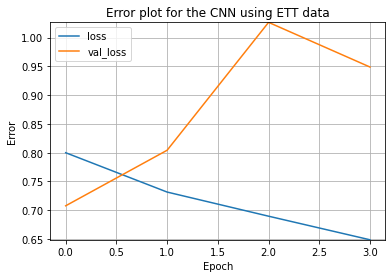

In [34]:
model.save("CNN models/"+cath)
plot_loss(historyCNN,'CNN',cath)

CNN accuracy is 0.6507936507936508


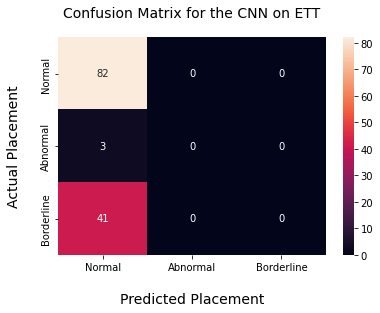

              precision    recall  f1-score   support

      Normal       0.65      1.00      0.79        82
    Abnormal       0.00      0.00      0.00         3
  Borderline       0.00      0.00      0.00        41

    accuracy                           0.65       126
   macro avg       0.22      0.33      0.26       126
weighted avg       0.42      0.65      0.51       126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
test_dir = 'images_split/'+cath+'/test'
test_image_paths=list_abs_paths_in_dir(test_dir)
test_filenames=get_filenames_of_abs_paths(test_image_paths)
# Create two dataframes for training and validation
test_df = trial[trial['image_file'].isin(test_filenames)]
test_df = test_df.reset_index(drop=True)
test_df.drop_duplicates(subset='StudyInstanceUID', keep="first",inplace=True)
test_labels=test_df['outcome'].tolist()
batch_size=32
test_coord_list=test_df['resized data'].tolist()
for i in range(len(test_coord_list)):
    test_coord_list[i]=list(ast.literal_eval(test_coord_list[i]))
    for j in range(len(test_coord_list[i])):
        test_coord_list[i][j]=tuple(test_coord_list[i][j])        
test_data_generator = CustomDataGenerator(test_image_paths,test_labels, test_coord_list, batch_size, increase_pixel_intensity)
# Load your pre-trained model (the one trained with coordinates)
loaded_model = tf.keras.models.load_model('CNN models/'+cath)

# Make predictions on the test data without coordinates
logits = loaded_model.predict(test_data_generator)
preds=tf.argmax(tf.nn.softmax(logits), 1)
true_labels = np.array(test_labels)
plt_cnf_mat('CNN',cath,true_labels,preds)
print(classification_report(y_true=true_labels,y_pred=preds,target_names=['Normal','Abnormal','Borderline']))

# Generative AI Acknowledgement
I acknowledge the use of ChatGPT https://chat.openai.com to generate code for use in processing data and creating neural networks. The output from these prompts was used to test image data on neural networks. 

The list of prompts were:
* How to build a ResNet50 CNN
* How to create a custom image data loader that modies pixel intensity